In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=0.5,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

In [2]:
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils

# Get K2 data

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 211990866.
('Transitmask:', array([], dtype=int64))
Using *GP* to flatten (can be 'GP', 'Median', or default to SavGol)
there can still be leftover bad points, so sigma clipping is recommended
Also might be good to rerun with transitmask set
WARNING [astropy._showwarning()]: Input data contains invalid values (NaNs or infs), which were automatically masked.


/Users/Sophie/anaconda2/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/Sophie/anaconda2/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


3663
3525
Using period range [  1.  50.]
Overwriting: df= [  9.80000000e-05] fmin= 0.02 freq_range [ 0.02  1.  ]
Computing bls...
=====Results====
Best period: 1.67387549045
Best freq: 0.597416
Depth: 0.000194017952245
Epoch: 2307.72315536
Number of transits: 44
Optimization terminated successfully.
('Per=', 1.6738261994997472, 'epoch=', 2307.7229406230117)


../src/blsMOD.py:170: RuntimeWarning: invalid value encountered in divide
  self._folded_binned_flux = y/ibi


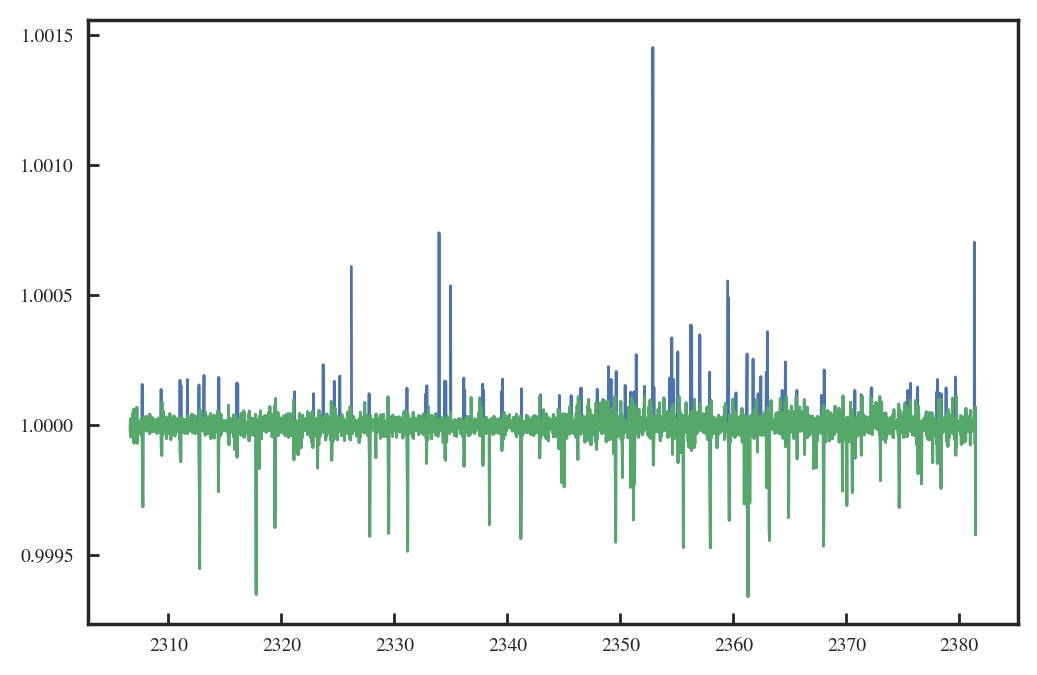

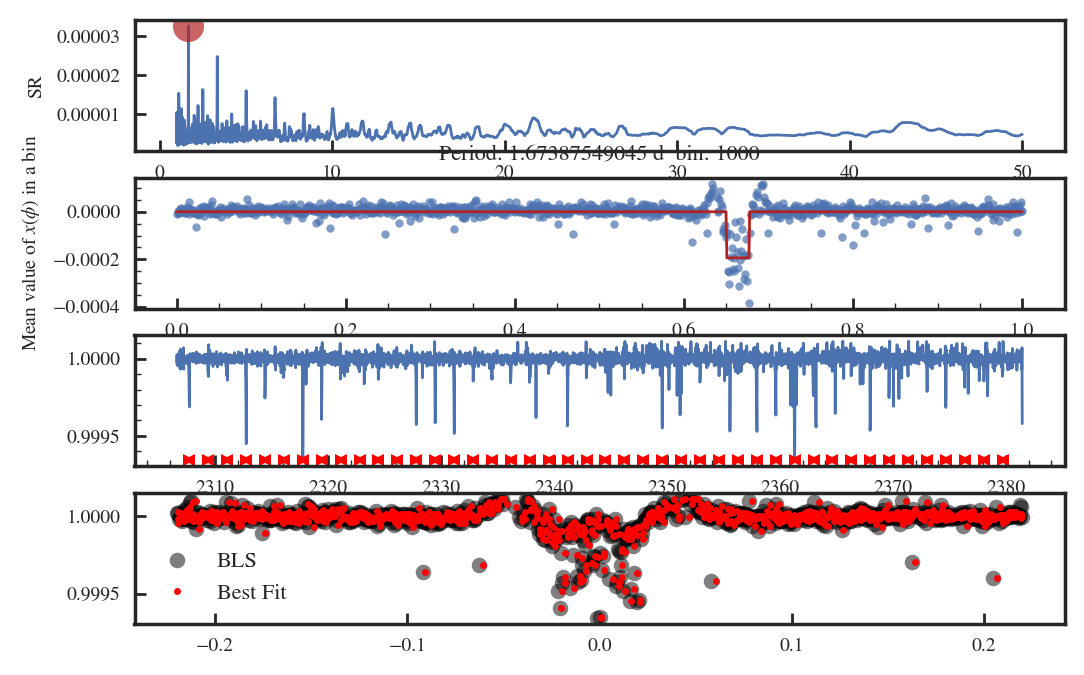

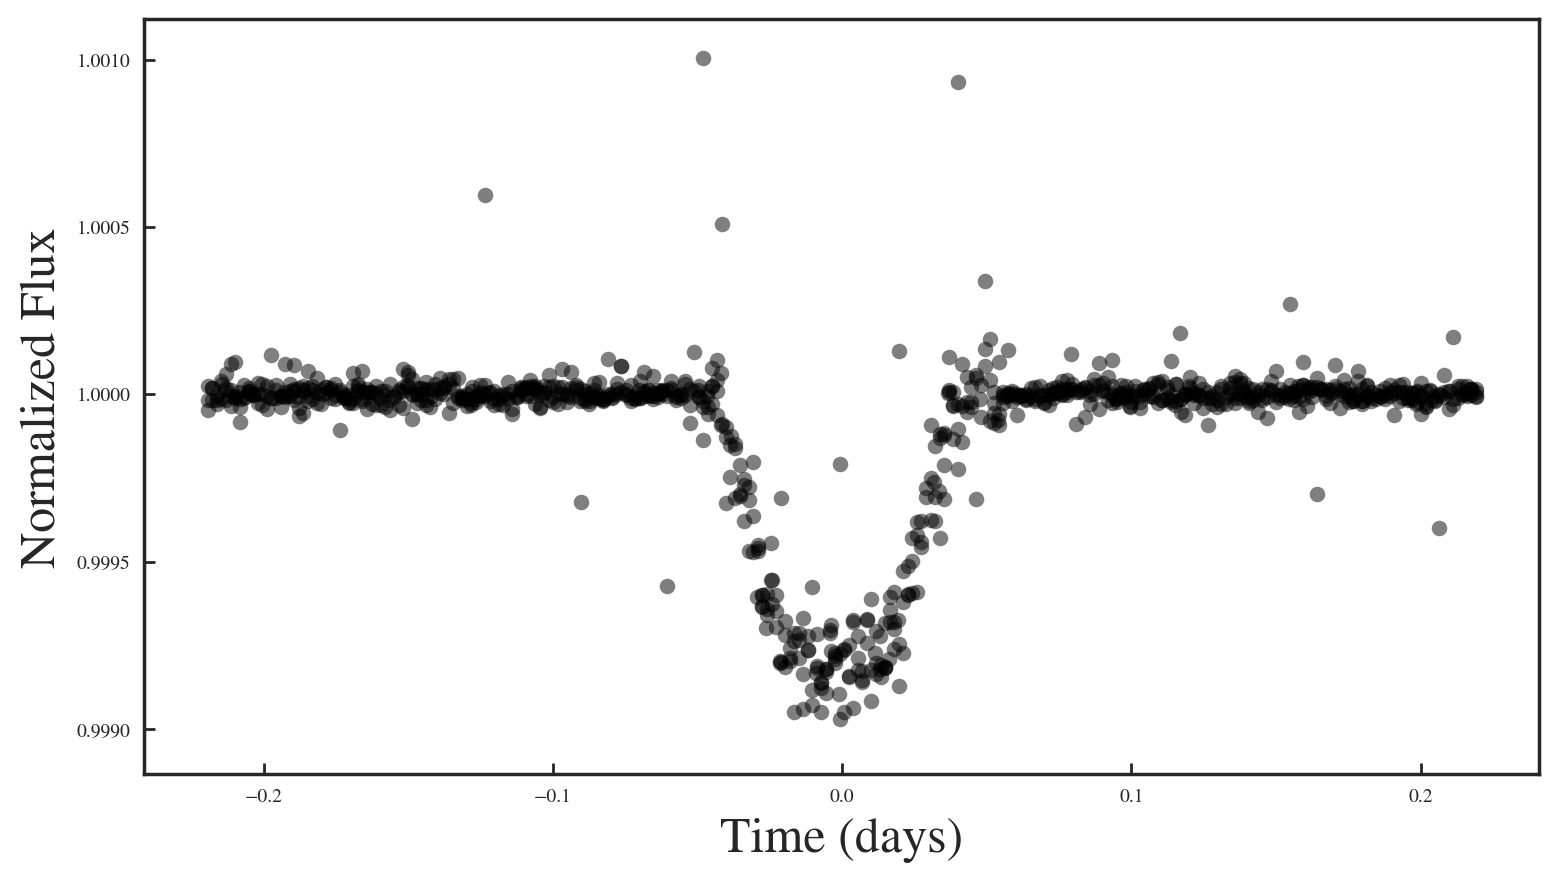

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 211990866.
('Transitmask:', array([2922, 3414, 3329, 1035, 1036, 1037, 1038, 1039, 1040, 3331, 3332,
       3247, 2183, 3333,  544,  545,  546,  547,  548, 3249, 2678, 3002,
       3251,   52,   53,   54,   55,   56,   57, 3167, 3168, 3083, 3088,
       3169, 3412, 1609, 1610, 1611, 1612, 1613, 3085, 3086, 3001, 3087,
       1117, 1118, 1119, 1120, 1121, 1122, 3003, 3004, 3005, 2920,  626,
        627,  628,  629,  630, 2921, 2101, 2923, 2838,  134,  135,  136,
        137,  138,  139, 2596, 2840, 2187, 2511, 2841, 2756, 1691, 1692,
       1693, 1694, 1695, 3415, 2265, 3006, 3330, 2759, 2674, 1199, 1200,
       1201, 1202, 1203, 1204, 2676, 2677, 2592,  708,  709,  710,  711,
        712, 2594, 2595, 2510,  216,  217,  218,  219,  220, 2269, 2512,
       2513, 2428, 1773, 1774, 1775, 1776, 1777, 2105, 2429, 2431, 2346,
       1281, 1282, 1283, 1284, 1285, 3334, 2348, 3084, 32

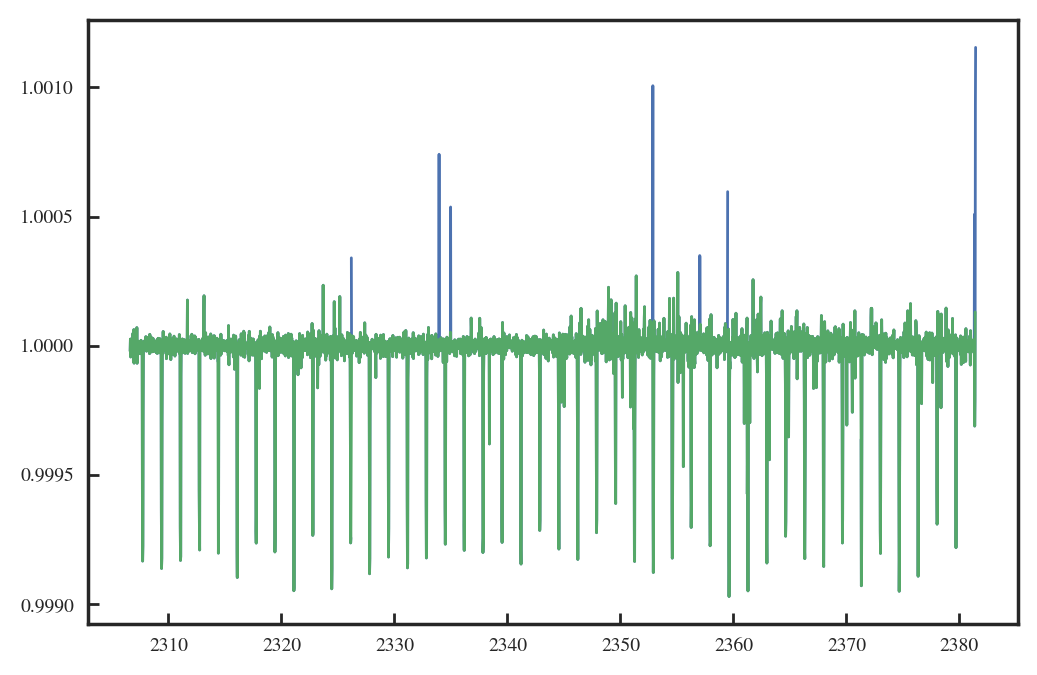

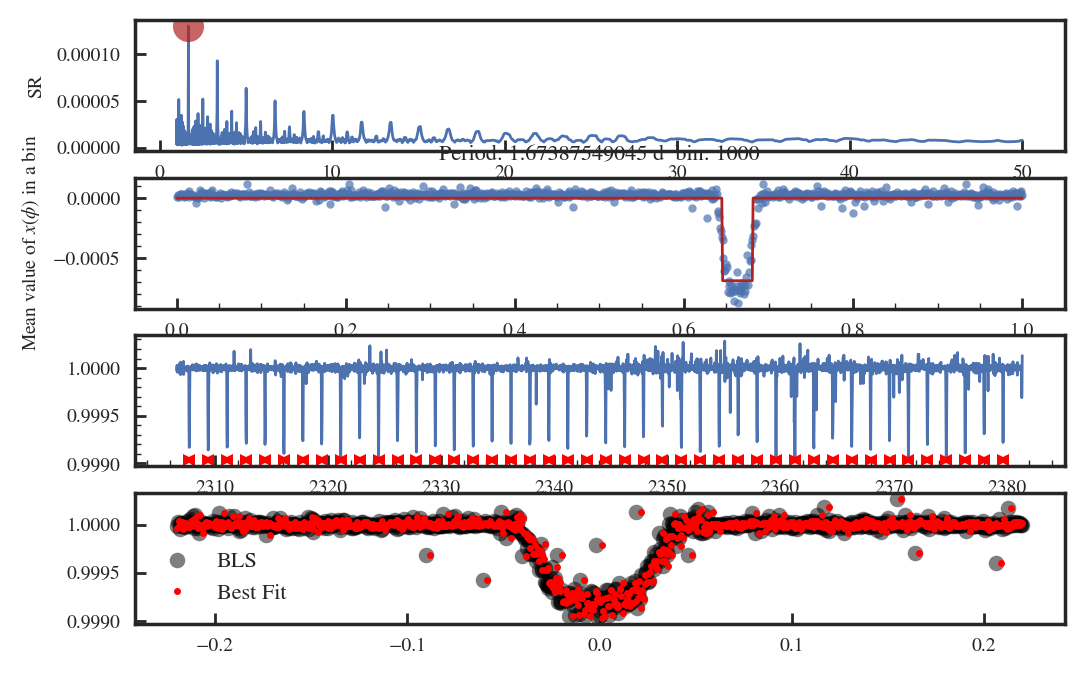

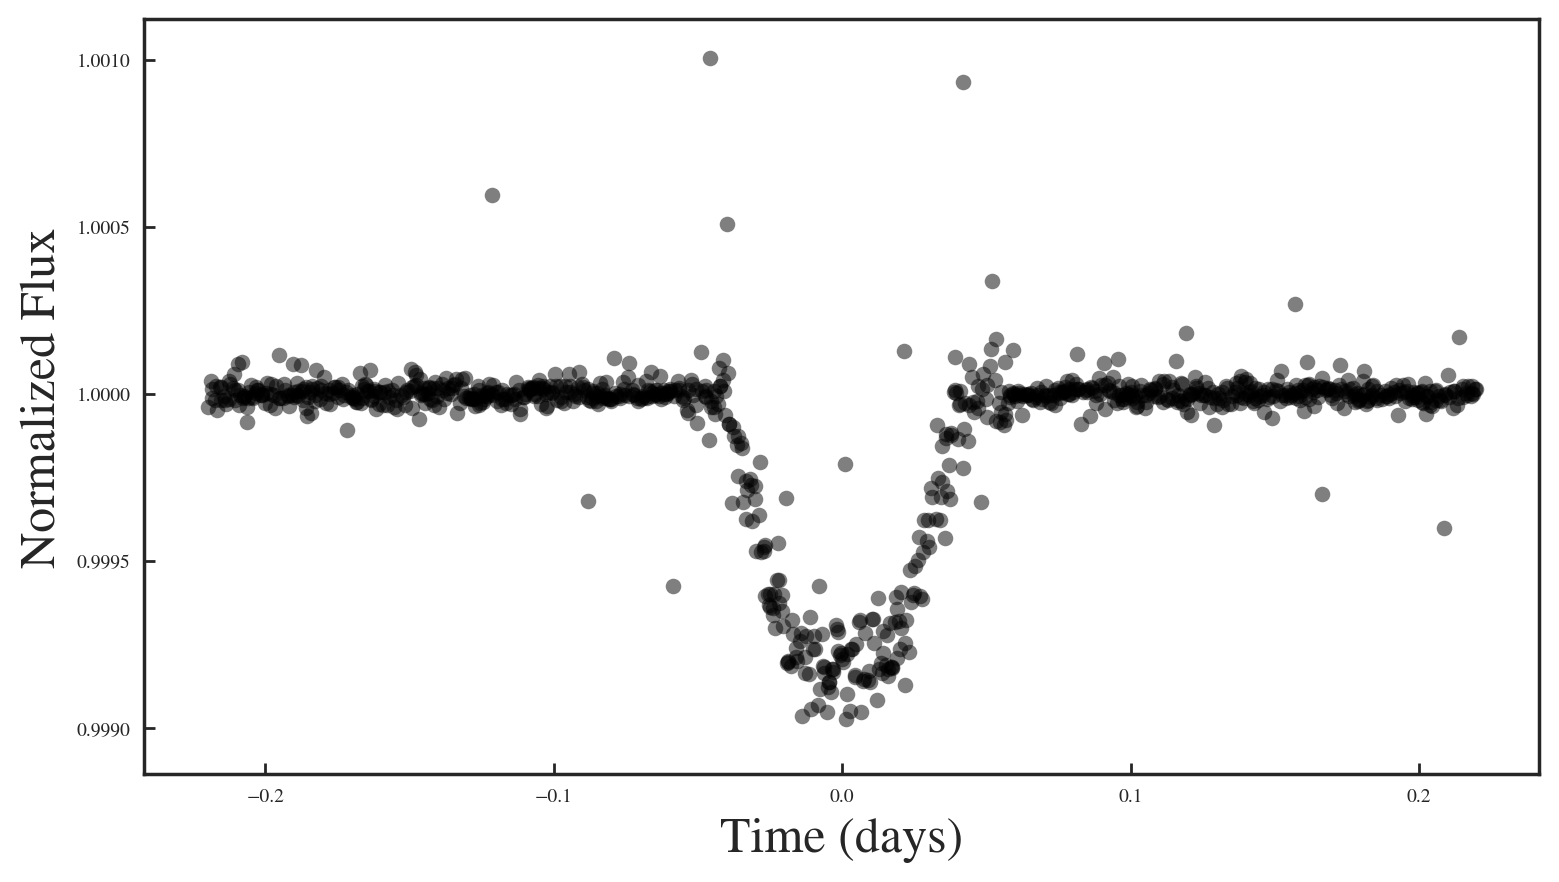

In [3]:
DUR = 0.11
EP = epicblsmulti.EVERESTBLS(211990866,sigma=15,sigma_upper=2.,flatten_method="GP")
planet = EP(dur=DUR)
EP = epicblsmulti.EVERESTBLS(211990866,sigma=15,sigma_upper=2.,flatten_method="GP",transitmask=EP.star.transitmask)
planet = EP(dur=DUR)

('Using planet with t0=', 2307.7201720355079, 'and P=', 1.6738482092294309)
Using median filtered data -- assumes you have run that from beginning!


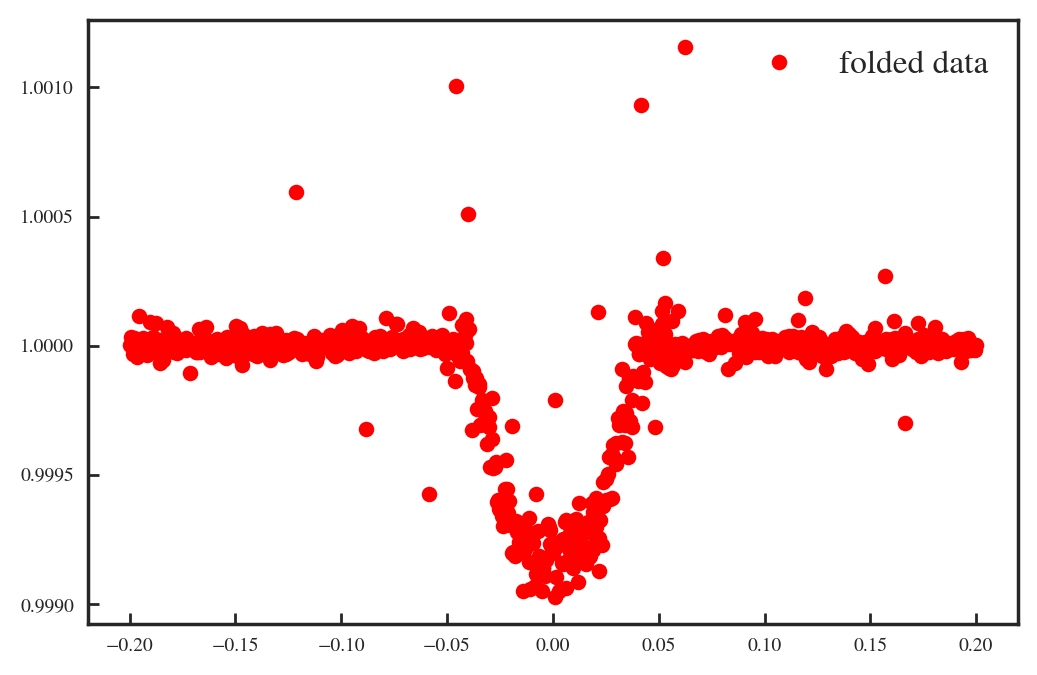

In [4]:
df = EP.get_cutout_phased_df(dur=0.4,sigma=None)
df = df.reset_index(drop=True)
df= df.sort_values("x")

866
[172 241 309 334 349 353 393 416 438 483 484 505 520 527 540 548 572 772
 794]
847


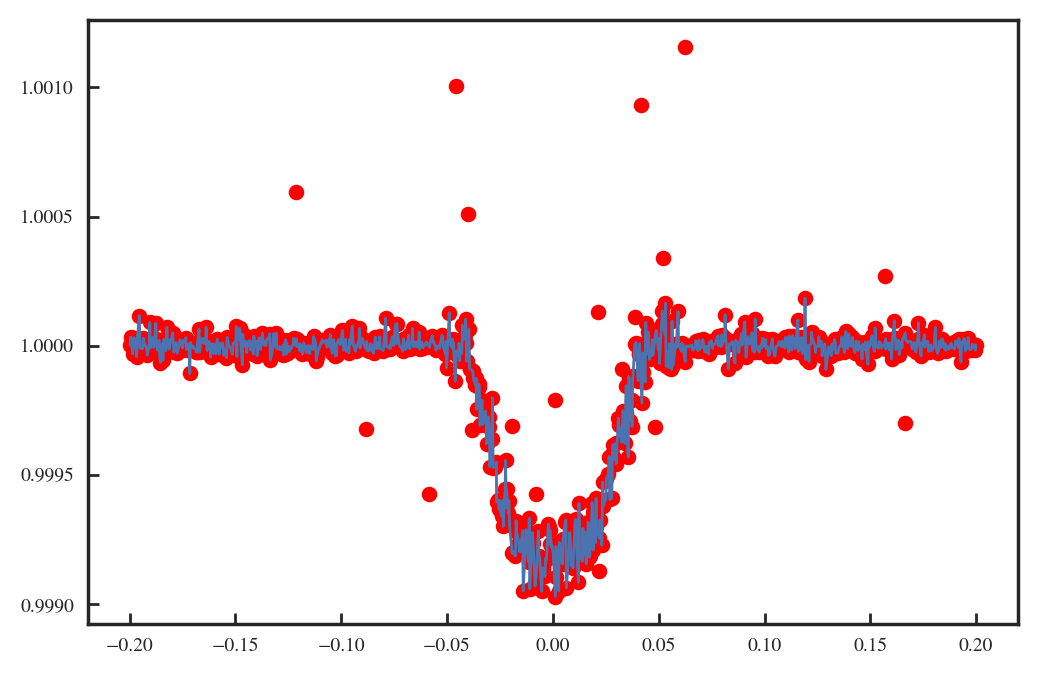

In [5]:
t,f,m,mm = k2help.median_filter_and_sigma_clip(df.x.values,df.y.values,return_mask=True,sigma=4.)
print(len(df))
print(m)
plt.plot(df.x, df.y,"r.")
dfmm= df.drop(m)
t_fold_final = dfmm.x
f_fold_final = dfmm.y
plt.plot(dfmm.x,dfmm.y)
print(len(dfmm))

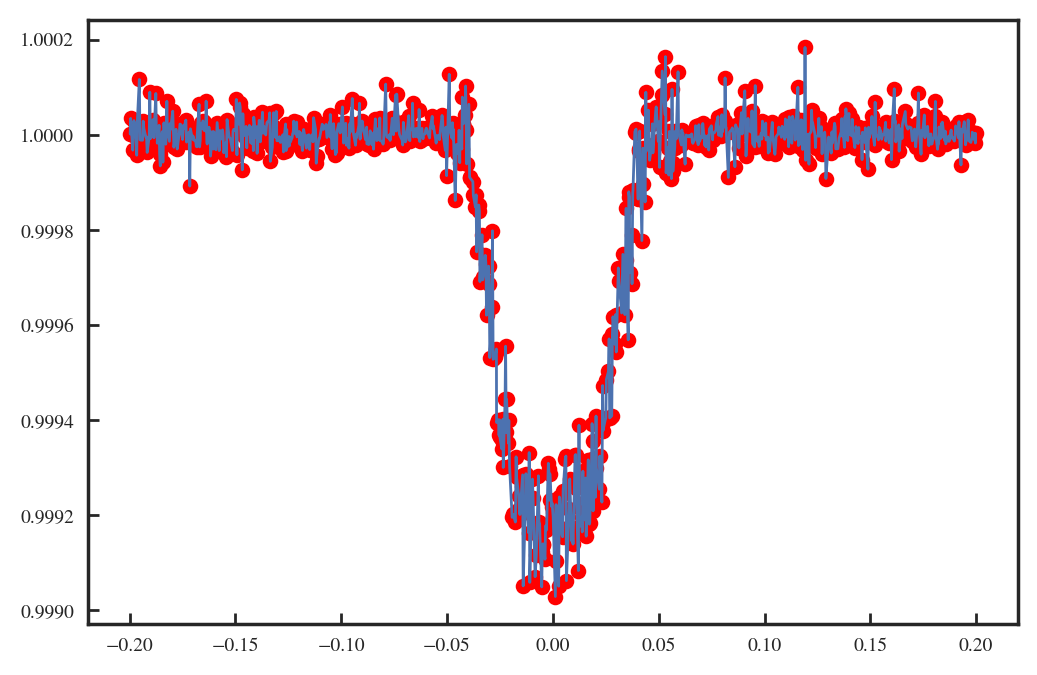

In [6]:
dfmm_s = dfmm.sort_index()
dfmm_s["time"] = dfmm_s.time.values + k2help.KEPLER_JD_OFFSET
plt.plot(dfmm_s.x,dfmm_s.y,"r.")
plt.plot(dfmm.x,dfmm.y)

In [7]:
dfmm_s.to_csv("../data/k2_100b/K2_data_k2_100b_final.csv")

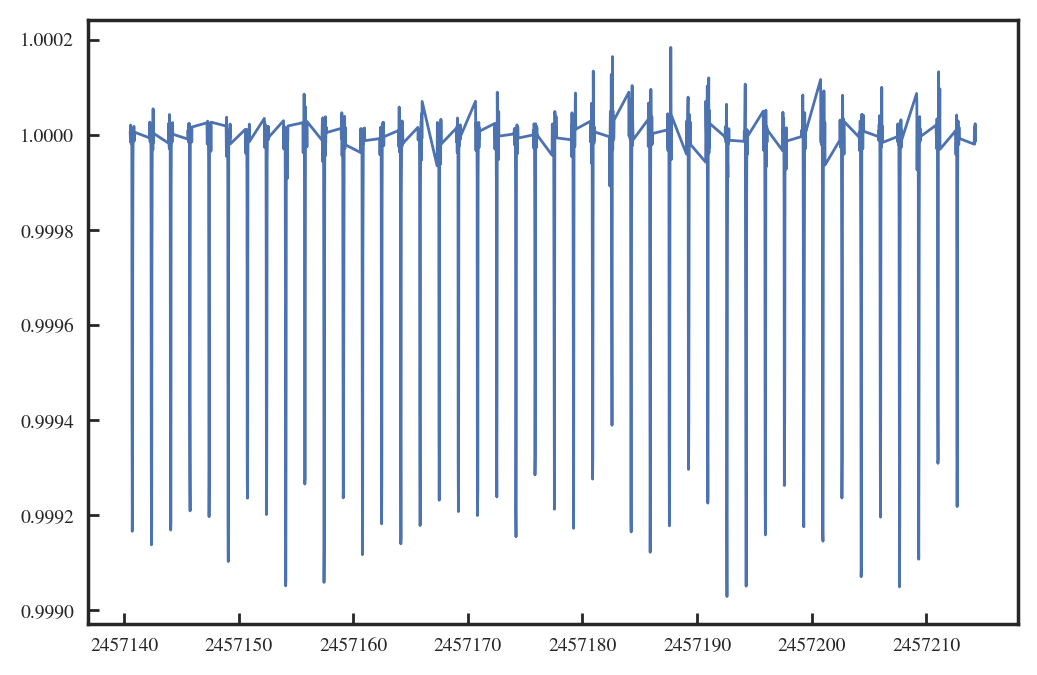

In [8]:
dfmm_s = dfmm_s.sort_values("index")
plt.plot(dfmm_s.time,dfmm_s.y)

In [9]:
import utils
_t0   = planet.get_attributeAndError("_pl_tranmid")[0]
ii   = planet.get_attributeAndError("_pl_orbincl")[0:2]
pp   = planet.get_attributeAndError("_pl_orbper")[0:2]
rprs = planet.get_attributeAndError("_pl_ratror")[0:2]
aRs  = planet.get_attributeAndError("_pl_ratdor")[0:2]

_p = np.log10(pp[0])
print("log(P)",mcmc_utils.err_logP_from_p(pp))
print("cos(i)",mcmc_utils.err_cosi_from_i(ii))
print("RpRs",rprs)
print("log(aRs)",mcmc_utils.err_logaRs_from_aRs(aRs))
print(_p)
print(_t0)

log(P) [0.2237160720067079, nan]
cos(i) [0.011609805792515681, nan]
RpRs (0.026351583845798623, nan)
log(aRs) [0.92947237179298625, nan]
0.223716072007
2457140.72017


# Read Ground Based 

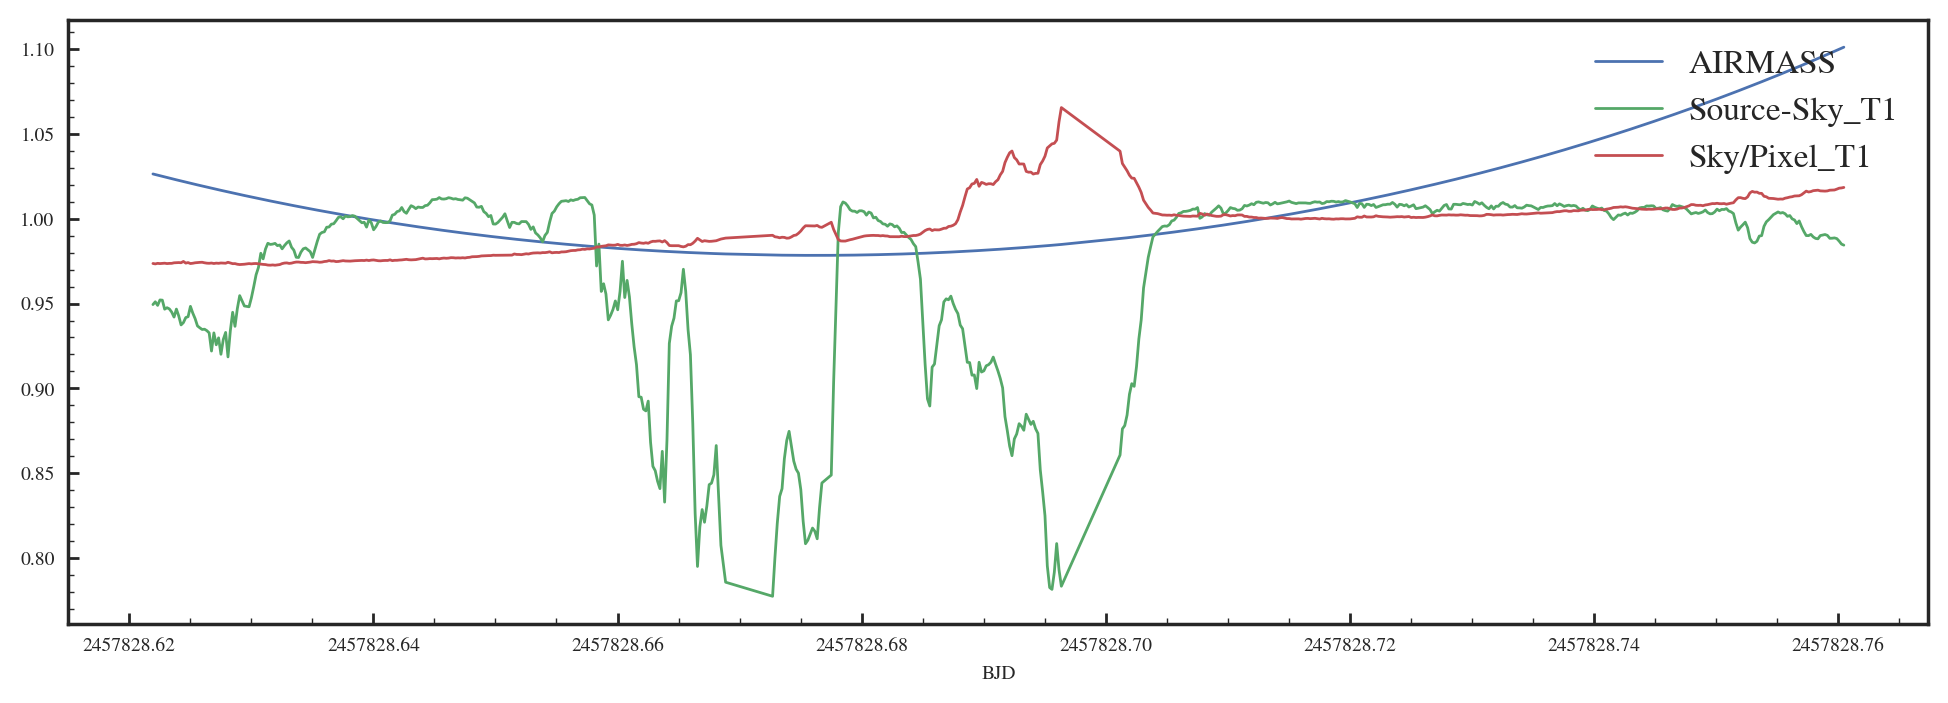

In [10]:
df_ground = pd.read_csv("../data/k2_100b/Processed_k2-100_sdssi_4x4_quad_fast_14_measurements.xls",sep="\t")
# Take out bad sky points
df_ground = df_ground[0:-20]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground.AIRMASS))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground["Source-Sky_T1"]))
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Sky/Pixel_T1"])-1)*0.1)+1.)

ax.set_xlabel("BJD")
ax.legend(loc="upper right",fontsize=12)
ax.minorticks_on()

### Calculate Scintillation errorbars

In [11]:
# Define variables
t_ground = df_ground.BJD_TDB.values
f_ground = df_ground.rel_flux_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)
err_ground = df_ground.rel_flux_err_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)

# Other params
NREFSTARS = 5.
cadence = np.median(np.diff(t_ground))*24.*60.*60.
print("Cadence {}s".format(cadence))

# Calculate the mean values for scintillation and photon to plot on the plot
final_unbinned_scint_noise = utils.scintillation_noise(350.,np.mean(df_ground["AIRMASS"]),cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
final_unbinned_phot_noise = np.mean(df_ground.rel_flux_err_T1)
print("Mean photon error: {}".format(final_unbinned_phot_noise))
print("Mean scint error: {}".format(final_unbinned_scint_noise))

# Calculate full array of errors including scintilation
scint_error = utils.scintillation_noise(350.,df_ground.AIRMASS.values,cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
tot_error = np.sqrt(scint_error**2.+err_ground**2.)

Cadence 16.5888056159s
Mean photon error: 0.000997078582435
Mean scint error: 0.000408551831247


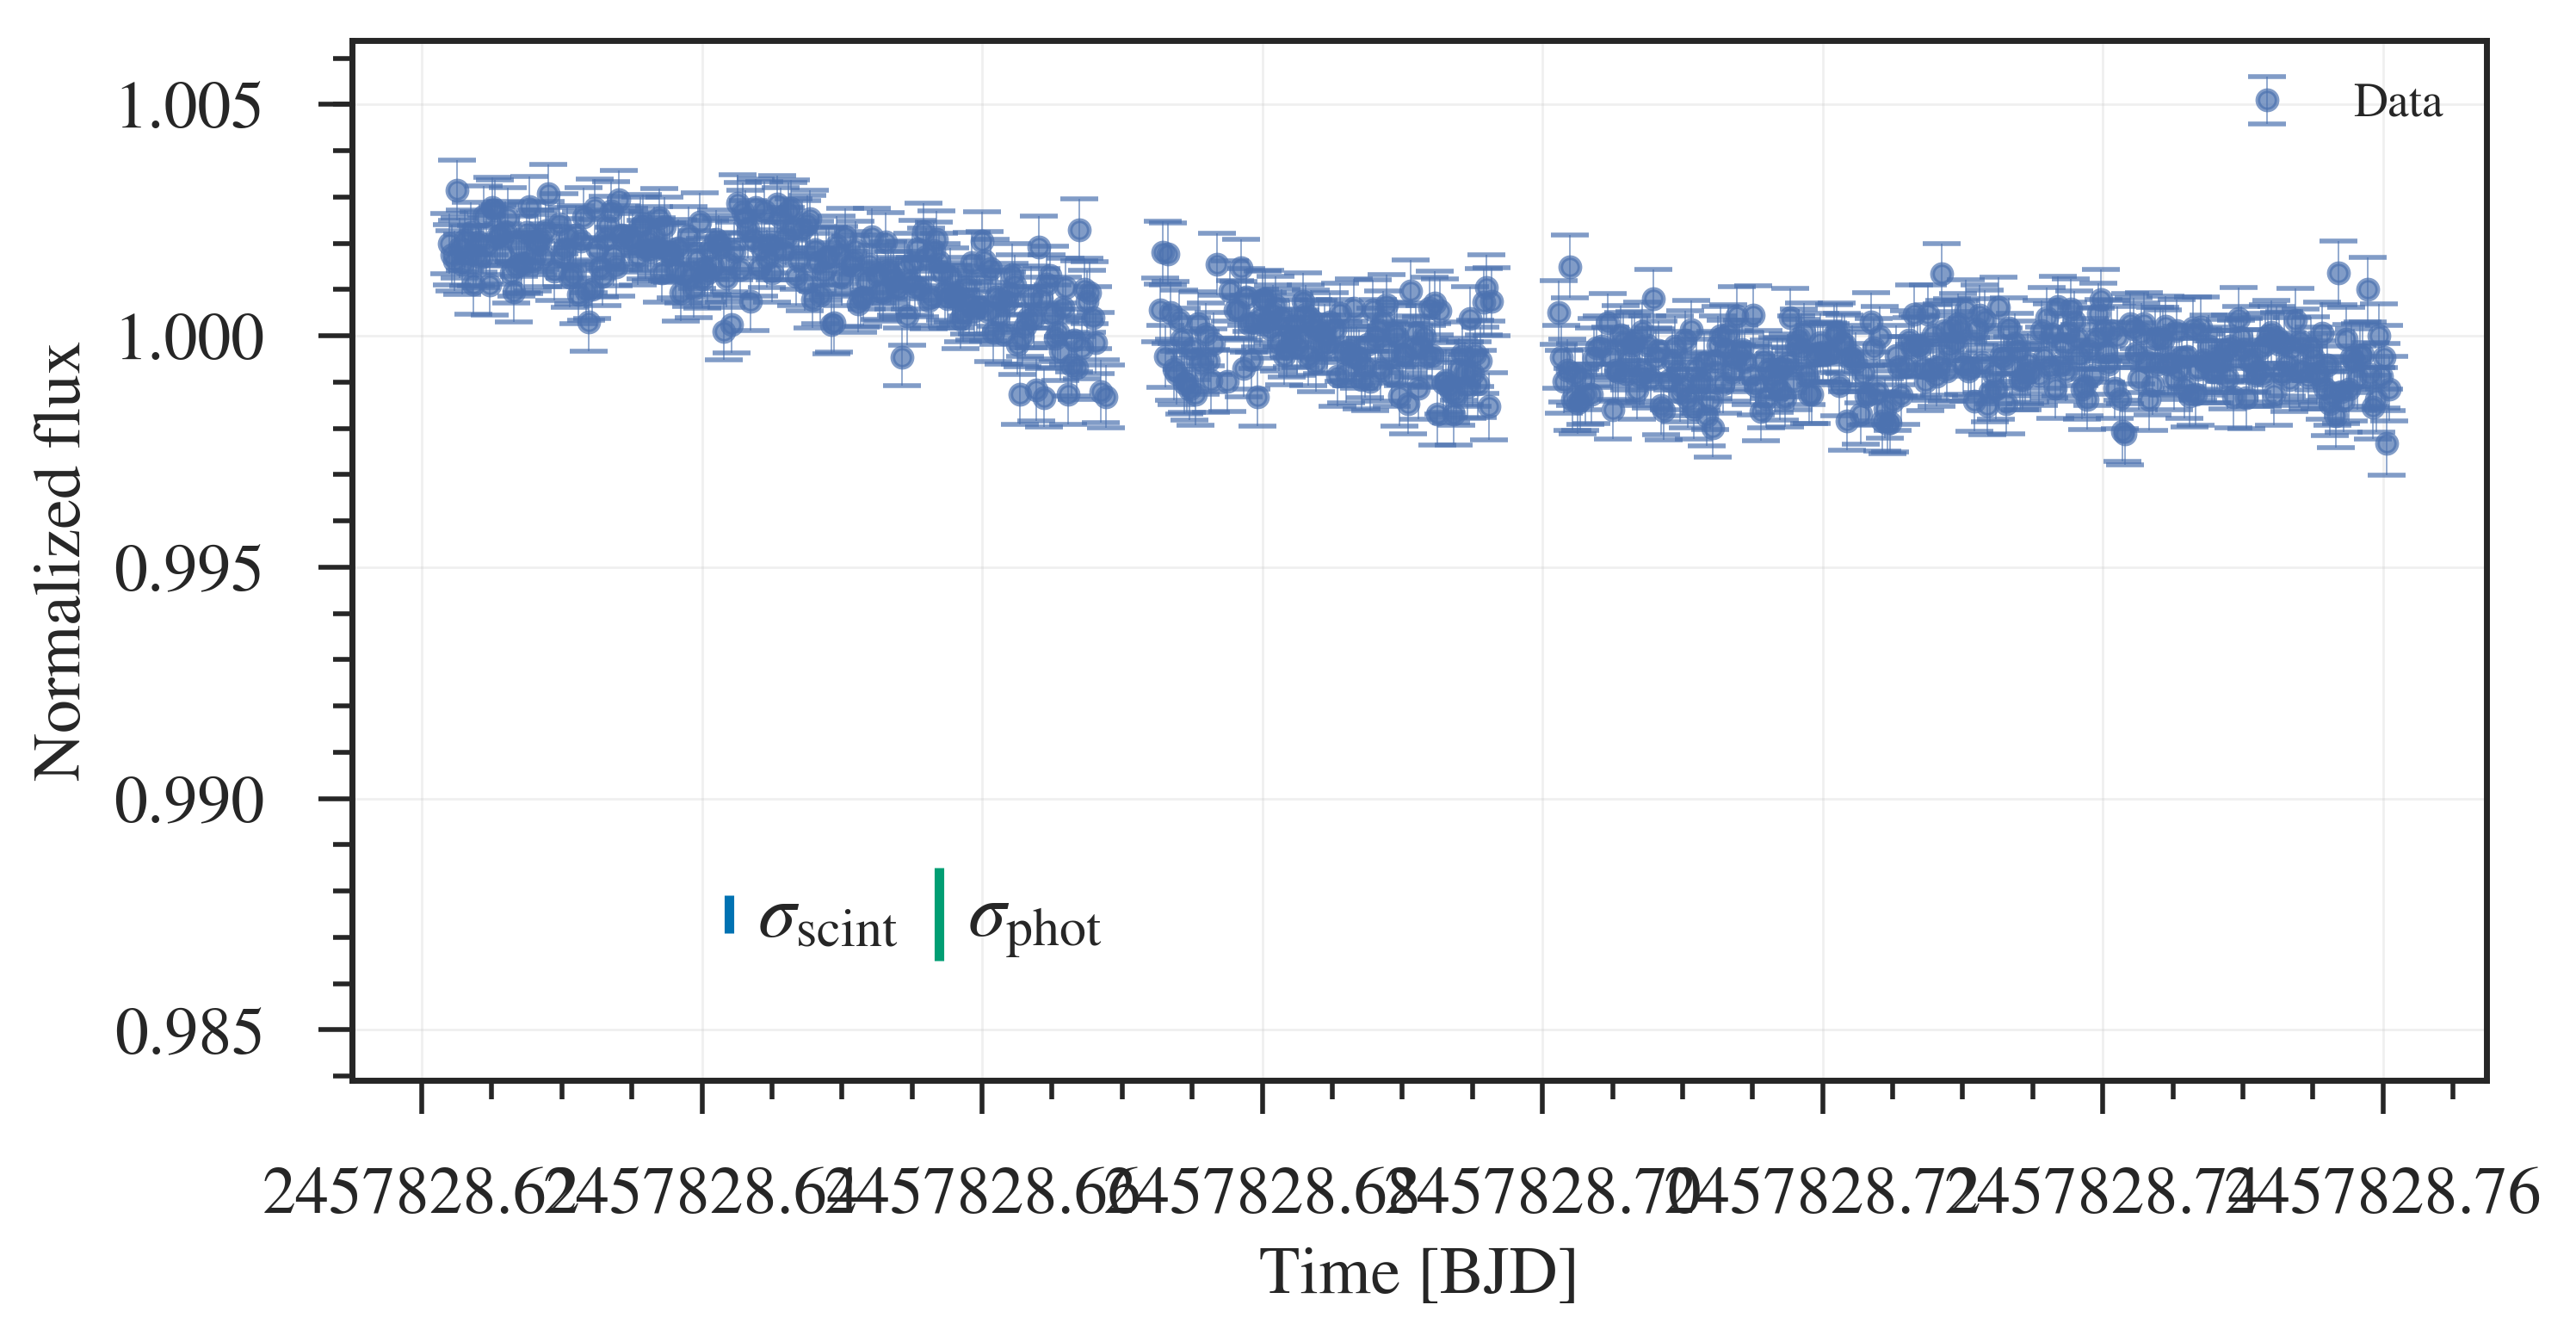

In [12]:
import plot_transits
fig, ax = plt.subplots(figsize=(8,4))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=14)
ax.set_ylabel("Normalized flux",fontsize=14)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=10)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=14)

In [13]:
#import astropylib

ii   = planet.get_attributeAndError("_pl_orbincl")[0:2]
pp   = planet.get_attributeAndError("_pl_orbper")[0:2]
rprs = planet.get_attributeAndError("_pl_ratror")[0:2]
aRs  = planet.get_attributeAndError("_pl_ratdor")[0:2]

_p = np.log10(pp[0])
_t0   = planet.get_attributeAndError("_pl_tranmid")[0]

print("log(P)",mcmc_utils.err_logP_from_p(pp))
print("cos(i)",mcmc_utils.err_cosi_from_i(ii))
print("RpRs",rprs)
print("log(aRs)",mcmc_utils.err_logaRs_from_aRs(aRs))
print(_p)
print(_t0)

log(P) [0.2237160720067079, nan]
cos(i) [0.011609805792515681, nan]
RpRs (0.026351583845798623, nan)
log(aRs) [0.92947237179298625, nan]
0.223716072007
2457140.72017


In [14]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.data1= {"time"  : dfmm_s.time.values,  # phase folded time in days (centered on 0)
                    "flux"   : dfmm_s.y.values   # phase folded flux
                    }
        self.data2= {"time"   : df_ground.BJD_TDB.values,
                    "flux"   : df_ground.rel_flux_T1.values,
                    "error"  : df_ground.rel_flux_err_T1.values,
                    "line"   : (df_ground.BJD_TDB.values-df_ground.BJD_TDB.values[0])/np.nanmean(df_ground.BJD_TDB.values-df_ground.BJD_TDB.values[0]),
                    "airmass": df_ground.AIRMASS.values/np.nanmean(df_ground.AIRMASS.values),
                    "x"      : df_ground["X(FITS)_T1"].values/np.nanmean(df_ground["X(FITS)_T1"].values),
                    "y"      : df_ground["Y(FITS)_T1"].values/np.nanmean(df_ground["Y(FITS)_T1"].values)}
                    #"meridian": meridian}
        #####
        
        
        
        self.priors = [UP(2457828.694-0.01    ,2457828.694+0.01 , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       #UP( _t0 -0.01           , _t0+0.01               , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       UP( _p  -0.001          , _p +0.001              , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       #NP( np.log10(1.673906)  ,0.000012          , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       UP( 0                   ,0.2               , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   2 - cos(i)
                       UP( 0.0                 , 0.1                    , 'RpRs_1'     ,r'$R_p/R_s_1$'             ,priortype="model"),
                       UP( 0.0                 ,0.05              , 'RpRs_2'     ,r'$R_p/R_s_2$'             ,priortype="model"),  ##   3 - rp/rstar
                       UP( 0.8                 ,1.0              , 'log(a/Rs)',r'$\log(a/R_s)$'         ,priortype="model"),  ##   4 - log(a/rstar)     
                       #UP( 0.                 ,1.                , 'q1'       ,r'$q_1$'                 ,priortype="model"),  ##   5 - q1
                       #UP( 0.                 ,1.                , 'q2'       ,r'$q_2$'                 ,priortype="model"),  ##   6 - q2
                       UP( 1.98                ,1.995             , 'fraw2'     ,r'fraw2'                  ,priortype="baseline"),##  7 - Baseline constant
                       UP( 0.9                 , 1.1              , 'fraw1'     ,r'fraw1'                  ,priortype="baseline"),  ##   7 - Baseline constant
                       UP( -0.1                ,0.1               , 'line'     ,r'line'                  ,priortype="detrend"),##  8 - Line
                       UP( 1e-5                , 50e-5            , 'err1'      ,r'error1'                 ,priortype="error")]  ##   8 - Baseline constant 
                       #UP( -0.1               , 0.1              , 'airmass'  ,r'airmass'               ,priortype="detrend"),##   9 - Airmass
                       #UP( -0.1               , 0.1              , 'x'        ,r'X'                     ,priortype="detrend")]##   10 - x
                       #UP( -0.1               , 0.1              , 'y'        ,r'Y'                     ,priortype="detrend")]##   11 - y
        
        # If we want to fix limb-dark parameters
        #self.limbdark = [0.42662803,0.30760637]#[ 0.16689202, 0.44493439] 
        self.ps     = PriorSet(self.priors)
        print("Baseline1 is at pv=",self.pv_lab2Idx("fraw1"))
        print("Baseline2 is at pv=",self.pv_lab2Idx("fraw2"))
        print("Error is at pv=",self.pv_lab2Idx("err1"))
        
    def pv_lab2Idx(self,pv_label):
        return np.where(np.array(self.ps.labels)==pv_label)[0][0]
            
    def compute_transit(self,pv,times1=None,times2=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        # First transit, K2
        self.params1 = batman.TransitParams()
        self.params1.t0 = pv[self.pv_lab2Idx("tc")]
        self.params1.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params1.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params1.rp = pv[self.pv_lab2Idx("RpRs_1")]
        self.params1.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params1.ecc = 0.
        self.params1.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_1")], pv[self.pv_lab2Idx("q2_1")]
        #self.params1.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params1.u = [0.34892527,0.29371571]
        self.params1.limb_dark = "quadratic"
        self.params1.fp = 0.001
        if times1 is None:
            times1 = self.data1["time"]
        transitmodel = batman.TransitModel(self.params1, times1, transittype='primary',supersample_factor=7,exp_time=0.020431801470066003)
        self.lc1 = transitmodel.light_curve(self.params1)
        
        # Second transit, ground,
        self.params2 = batman.TransitParams()
        self.params2.t0 = pv[self.pv_lab2Idx("tc")]
        self.params2.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params2.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params2.rp = pv[self.pv_lab2Idx("RpRs_2")]
        self.params2.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params2.ecc = 0.
        self.params2.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_2")], pv[self.pv_lab2Idx("q2_2")]
        #self.params2.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params2.u = [0.26217945,0.30166423]
        self.params2.limb_dark = "quadratic"
        self.params2.fp = 0.001
        if times2 is None:
            times2 = self.data2["time"]
        transitmodel = batman.TransitModel(self.params2, times2, transittype='primary')
        self.lc2 = transitmodel.light_curve(self.params2)

        return self.lc1, self.lc2      
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data2["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            detrend += pv[i]*(self.data2[self.ps.labels[i]]-1.)
        return detrend/pv[self.pv_lab2Idx("fraw2")]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            The full light curve model with a trend
        """
        f1, f2 = self.compute_transit(pv)
        # Return the flux from K2, and then detrended flux from ground
        return f1, f2 + self.detrend(pv)
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        NOTES:
            This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m1, flux_m2 = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        
        scaled_flux1  = self.data1["flux"]/pv[self.pv_lab2Idx("fraw1")]
        scaled_flux2  = self.data2["flux"]/pv[self.pv_lab2Idx("fraw2")]
        
        log_of_model1  = ll_normal_es(scaled_flux1, flux_m1, pv[self.pv_lab2Idx("err1")])
        log_of_model2  = ll_normal_ev(scaled_flux2, flux_m2, self.data2["error"])

        log_ln = log_of_priors + log_of_model1 + log_of_model2
        
        return log_ln

In [15]:
import trf
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
TF = trf.TransitFit(LPFunction)

Baseline1 is at pv= 7
Baseline2 is at pv= 6
Error is at pv= 9


In [29]:
TF.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.457829e+06  2.457829e+06  2.457829e+06  2.457829e+06    -0.002511
1       logP  2.237161e-01  2.227161e-01  2.247161e-01  2.237324e-01    -0.000016
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  6.135082e-03     0.093865
3     RpRs_1  5.000000e-02  0.000000e+00  1.000000e-01  2.609569e-02     0.023904
4     RpRs_2  2.500000e-02  0.000000e+00  5.000000e-02  3.120027e-02    -0.006200
5  log(a/Rs)  9.000000e-01  8.000000e-01  1.000000e+00  9.163034e-01    -0.016303
6      fraw2  1.987500e+00  1.980000e+00  1.995000e+00  1.988720e+00    -0.001220
7      fraw1  1.000000e+00  9.000000e-01  1.100000e+00  1.000016e+00    -0.000016
8       line  0.000000e+00 -1.000000e-01  1.000000e-01 -2.747778e-03     0.002748
9       err1  2.550000e-04  1.000000e-05  5.000000e-04  4.119133e-05     0.000214
LogLn value: -10980.2984194
Log prio

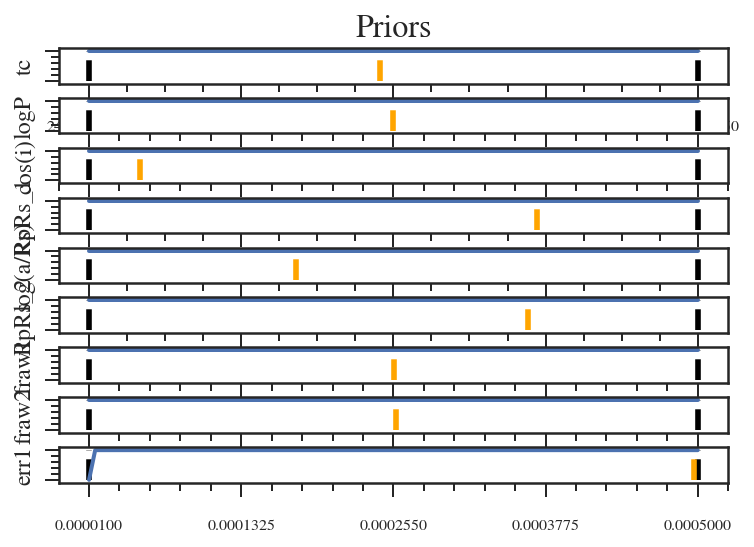

In [15]:
TF.lpf.ps.plot_all(TF.min_pv)

In [17]:
TF.minimize_PyDE(mc_iter=1000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.457829e+06  2.457829e+06  2.457829e+06  2.457829e+06    -0.001009
1       logP  2.237161e-01  2.227161e-01  2.247161e-01  2.237349e-01    -0.000019
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  7.405657e-02     0.025943
3     RpRs_1  5.000000e-02  0.000000e+00  1.000000e-01  2.382113e-02     0.026179
4     RpRs_2  2.500000e-02  0.000000e+00  5.000000e-02  2.829527e-02    -0.003295
5  log(a/Rs)  9.000000e-01  8.000000e-01  1.000000e+00  8.306710e-01     0.069329
6      fraw2  1.987500e+00  1.980000e+00  1.995000e+00  1.988816e+00    -0.001316
7      fraw1  1.000000e+00  9.000000e-01  1.100000e+00  9.999172e-01     0.000083
8       line  0.000000e+00 -1.000000e-01  1.000000e-01 -2.754339e-03     0.002754
9       err1  2.550000e-04  1.000000e-05  5.000000e-04  1.540503e-04     0.000101
LogLn value: -10222.4867716
Log prio

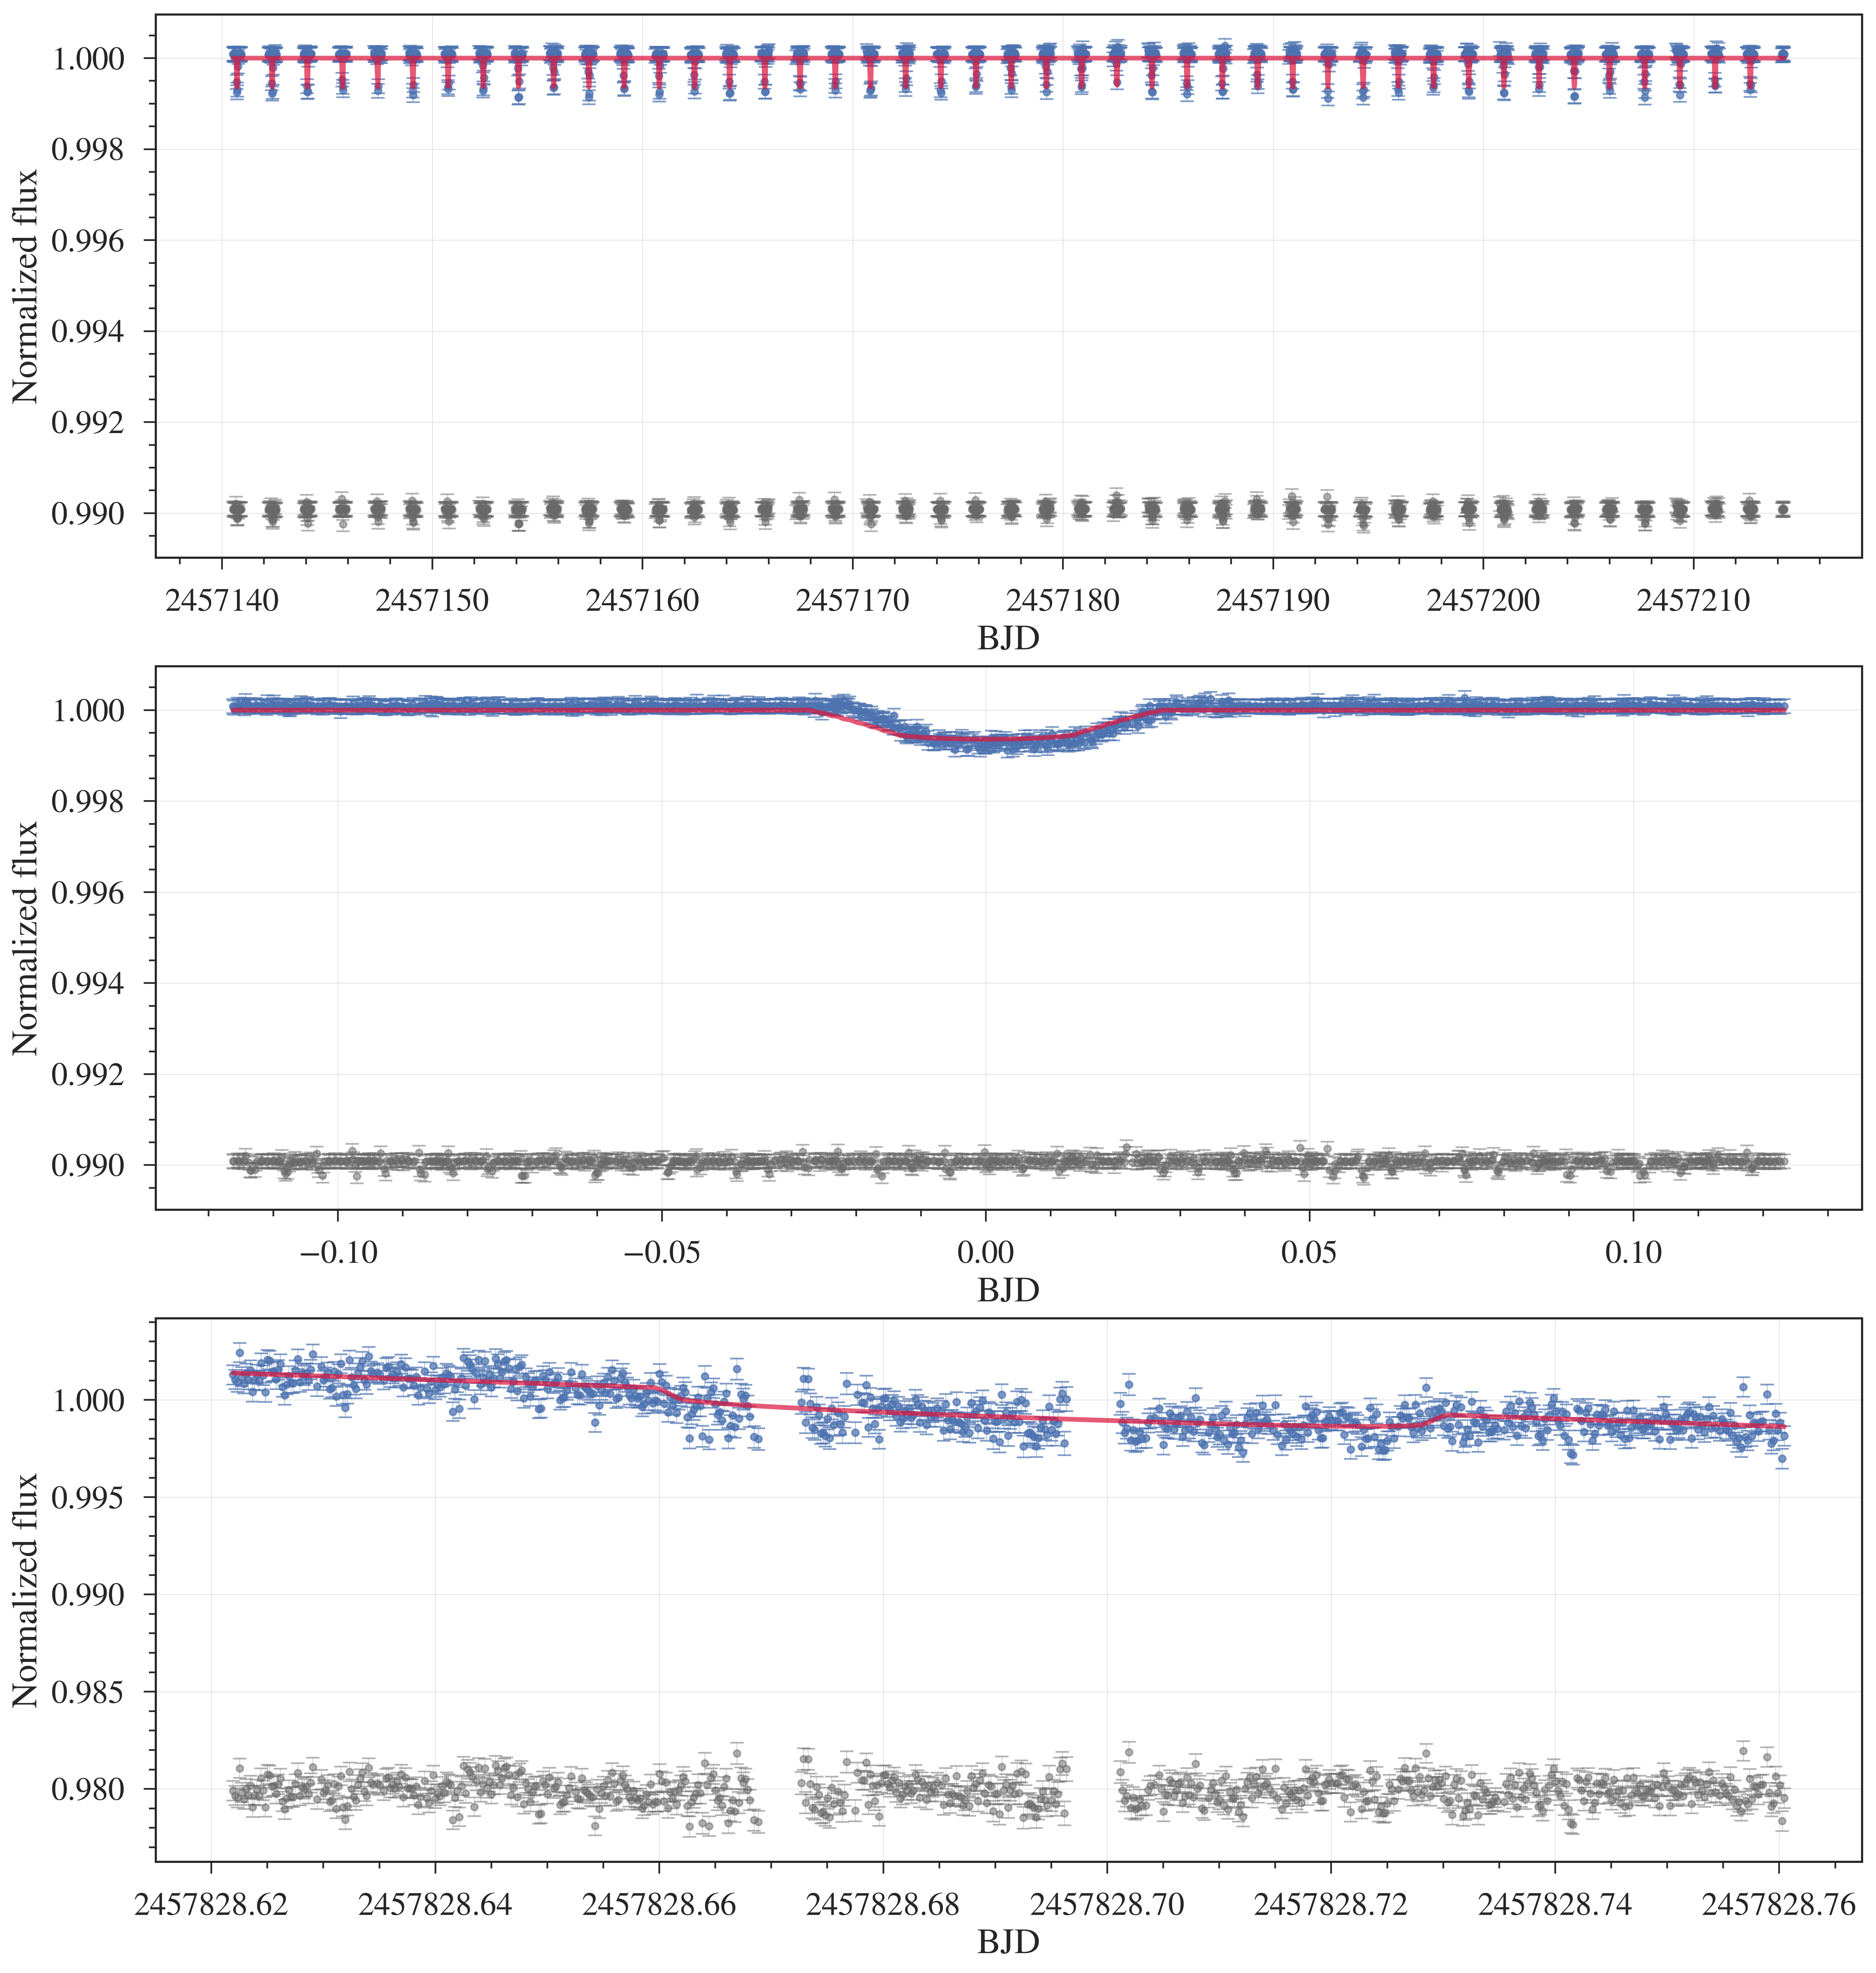

In [18]:
pv = TF.min_pv
t0  = pv[0]
p  = 10.**(pv[1])
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,20))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)

In [35]:
#TF.plot_chains()

In [37]:
#TF.plot_corner(burn=400,show_titles=True)

In [21]:
df = TF.get_df_flatchain()

In [22]:
df["P"] = 10.**df["logP"].values
df["i"] = np.rad2deg(np.arccos(df["cos(i)"].values))
df["aRs"] = 10.**df["log(a/Rs)"].values
# K2 parameters
df_param_k2 = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_1'].values,
                                                 df['aRs'].values,
                                                 st_rad=1.19,
                                                 st_raderr1=0.05,
                                                 st_teff=6120.,
                                                 st_teff_err1=90.)
# Ground based parameters
df_param_ground = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_2'].values,
                                                 df['aRs'].values,
                                                 st_rad=1.19,
                                                 st_raderr1=0.05,
                                                 st_teff=6120.,
                                                 st_teff_err1=90.)

Assuming
R_s: 1.19 +- 0.05
Teff: 6120.0 +- 90.0
Albedo: 0.3
Assuming
R_s: 1.19 +- 0.05
Teff: 6120.0 +- 90.0
Albedo: 0.3


### Ground-based parameters

In [23]:
df_param_ground

medvals       minus        plus  \
0   2.457829e+06    0.001177    0.000860   
1   1.673903e+00    0.000003    0.000002   
2   2.855005e-02    0.001428    0.001488   
3   3.702825e+00    0.239273    0.248471   
4   3.303445e-01    0.021347    0.022167   
5   8.151052e-04    0.000079    0.000087   
6   7.224695e+00    0.513171    0.534691   
7   3.992639e-02    0.003127    0.003350   
8   2.545950e+00    0.504894    0.608133   
9   8.608791e+01    1.163938    1.229856   
10  4.932088e-01    0.130734    0.101806   
11  0.000000e+00    0.000000    0.000000   
12  0.000000e+00    0.000000    0.000000   
13  1.127192e+03   41.712881   43.999486   
14  1.120364e+03  156.860190  185.443600   
15  6.671219e-02    0.000624    0.000692   
16  2.420273e-03    0.000327    0.000494   
17  2.457830e+06    0.001178    0.000862   

                                  values  \
0   $2457828.69346_{-0.0012}^{+0.00086}$   
1    $1.6739026_{-0.000003}^{+0.000002}$   
2           $0.0286_{-0.0014}^{+0.0015}$   
3                  $3.7_{-0.24}^{+0.25}$   
4               $0.33_{-0.021}^{+0.022}$   
5       $0.000815_{-0.00008}^{+0.00009}$   
6                 $7.22_{-0.51}^{+0.53}$   
7           $0.0399_{-0.0031}^{+0.0034}$   
8                 $2.55_{-0.50}^{+0.61}$   
9                   $86.1_{-1.2}^{+1.2}$   
10                $0.49_{-0.13}^{+0.10}$   
11                   $0.0_{-0.0}^{+0.0}$   
12                   $0.0_{-0.0}^{+0.0}$   
13              $1127.0_{-42.0}^{+44.0}$   
14            $1120.0_{-160.0}^{+190.0}$   
15       $0.06671_{-0.00062}^{+0.00069}$   
16       $0.00242_{-0.00033}^{+0.00049}$   
17  $2457829.53041_{-0.0012}^{+0.00086}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

### Parameters from K2 

In [24]:
df_param_k2

medvals       minus        plus  \
0   2.457829e+06    0.001177    0.000860   
1   1.673903e+00    0.000003    0.000002   
2   2.695314e-02    0.000456    0.000520   
3   3.494923e+00    0.165876    0.161505   
4   3.117967e-01    0.014798    0.014409   
5   7.264717e-04    0.000024    0.000028   
6   7.224695e+00    0.513171    0.534691   
7   3.992849e-02    0.003103    0.003325   
8   2.545950e+00    0.504894    0.608133   
9   8.608791e+01    1.163938    1.229856   
10  4.932088e-01    0.130734    0.101806   
11  0.000000e+00    0.000000    0.000000   
12  0.000000e+00    0.000000    0.000000   
13  1.127168e+03   41.724678   44.064597   
14  1.120271e+03  156.892076  185.722607   
15  6.657441e-02    0.000601    0.000651   
16  2.292108e-03    0.000316    0.000442   
17  2.457830e+06    0.001178    0.000862   

                                  values  \
0   $2457828.69346_{-0.0012}^{+0.00086}$   
1    $1.6739026_{-0.000003}^{+0.000002}$   
2        $0.02695_{-0.00046}^{+0.00052}$   
3                 $3.49_{-0.17}^{+0.16}$   
4              $0.312_{-0.015}^{+0.014}$   
5       $0.000726_{-0.00002}^{+0.00003}$   
6                 $7.22_{-0.51}^{+0.53}$   
7           $0.0399_{-0.0031}^{+0.0033}$   
8                 $2.55_{-0.50}^{+0.61}$   
9                   $86.1_{-1.2}^{+1.2}$   
10                $0.49_{-0.13}^{+0.10}$   
11                   $0.0_{-0.0}^{+0.0}$   
12                   $0.0_{-0.0}^{+0.0}$   
13              $1127.0_{-42.0}^{+44.0}$   
14            $1120.0_{-160.0}^{+190.0}$   
15       $0.06657_{-0.00060}^{+0.00065}$   
16       $0.00229_{-0.00032}^{+0.00044}$   
17  $2457829.53041_{-0.0012}^{+0.00086}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

In [25]:
def plot_lc(self,pv,times=None):
        """
        Plot the light curve for a given set of parameters pv
        
        INPUT:
        pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        EXAMPLE:
        
        """
        self.scaled_flux   = self.lpf.data["flux"]/pv[self.lpf.number_pv_baseline]
        self.scaled_flux_no_trend = self.scaled_flux - self.lpf.detrend(pv)
        self.model_trend   = self.lpf.compute_lc_model(pv)
        self.model_no_trend= self.lpf.compute_transit(pv)
        self.residual      = self.scaled_flux - self.model_trend
        try:
            self.scaled_error  = self.lpf.data["error"]/pv[self.lpf.number_pv_baseline]
        except Exception as e:
            self.scaled_error = pv[self.lpf.number_pv_error]/pv[self.lpf.number_pv_baseline]

        
        nrows = 3
        self.fig, self.ax = plt.subplots(nrows=nrows,sharex=True)
        self.ax[0].errorbar(self.lpf.data["time"],self.scaled_flux,yerr=self.scaled_error,elinewidth=0.3,lw=0,alpha=0.5,marker="o",barsabove=True,markersize=4,label="Data with trend")
        self.ax[0].plot(self.lpf.data["time"],self.model_trend,label="Model with trend")
        
        self.ax[1].errorbar(self.lpf.data["time"],self.scaled_flux_no_trend,yerr=self.scaled_error,elinewidth=0.3,lw=0,alpha=0.5,marker="o",markersize=4,label="Data, no trend")
        self.ax[1].plot(self.lpf.data["time"],self.model_no_trend,label="Model no trend")

        self.ax[2].plot(self.lpf.data["time"],self.residual,label="residual, std="+str(np.std(self.residual)),lw=0,marker="o",ms=3)
        [self.ax[i].minorticks_on() for i in range(nrows)]
        [self.ax[i].legend(loc="lower left",fontsize=8) for i in range(nrows)]
        self.ax[-1].set_xlabel("Time (BJD)")
        [self.ax[i].set_ylabel("Rel Flux") for i in range(nrows)]
        self.ax[0].set_title("Light curve")

# Plot with MCMC joint parameters

In [26]:
pv = TF.get_mean_values_mcmc_posteriors().medvals.values
t0  = TF.get_mean_values_mcmc_posteriors().medvals.values[0]
p  = 10.**TF.get_mean_values_mcmc_posteriors().medvals.values[1]
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)
model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)
model_trend1_no_trend,model_trend2_no_trend= TF.lpf.compute_transit(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]
scaled_flux2_no_trend = scaled_flux2 - TF.lpf.detrend(pv)

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

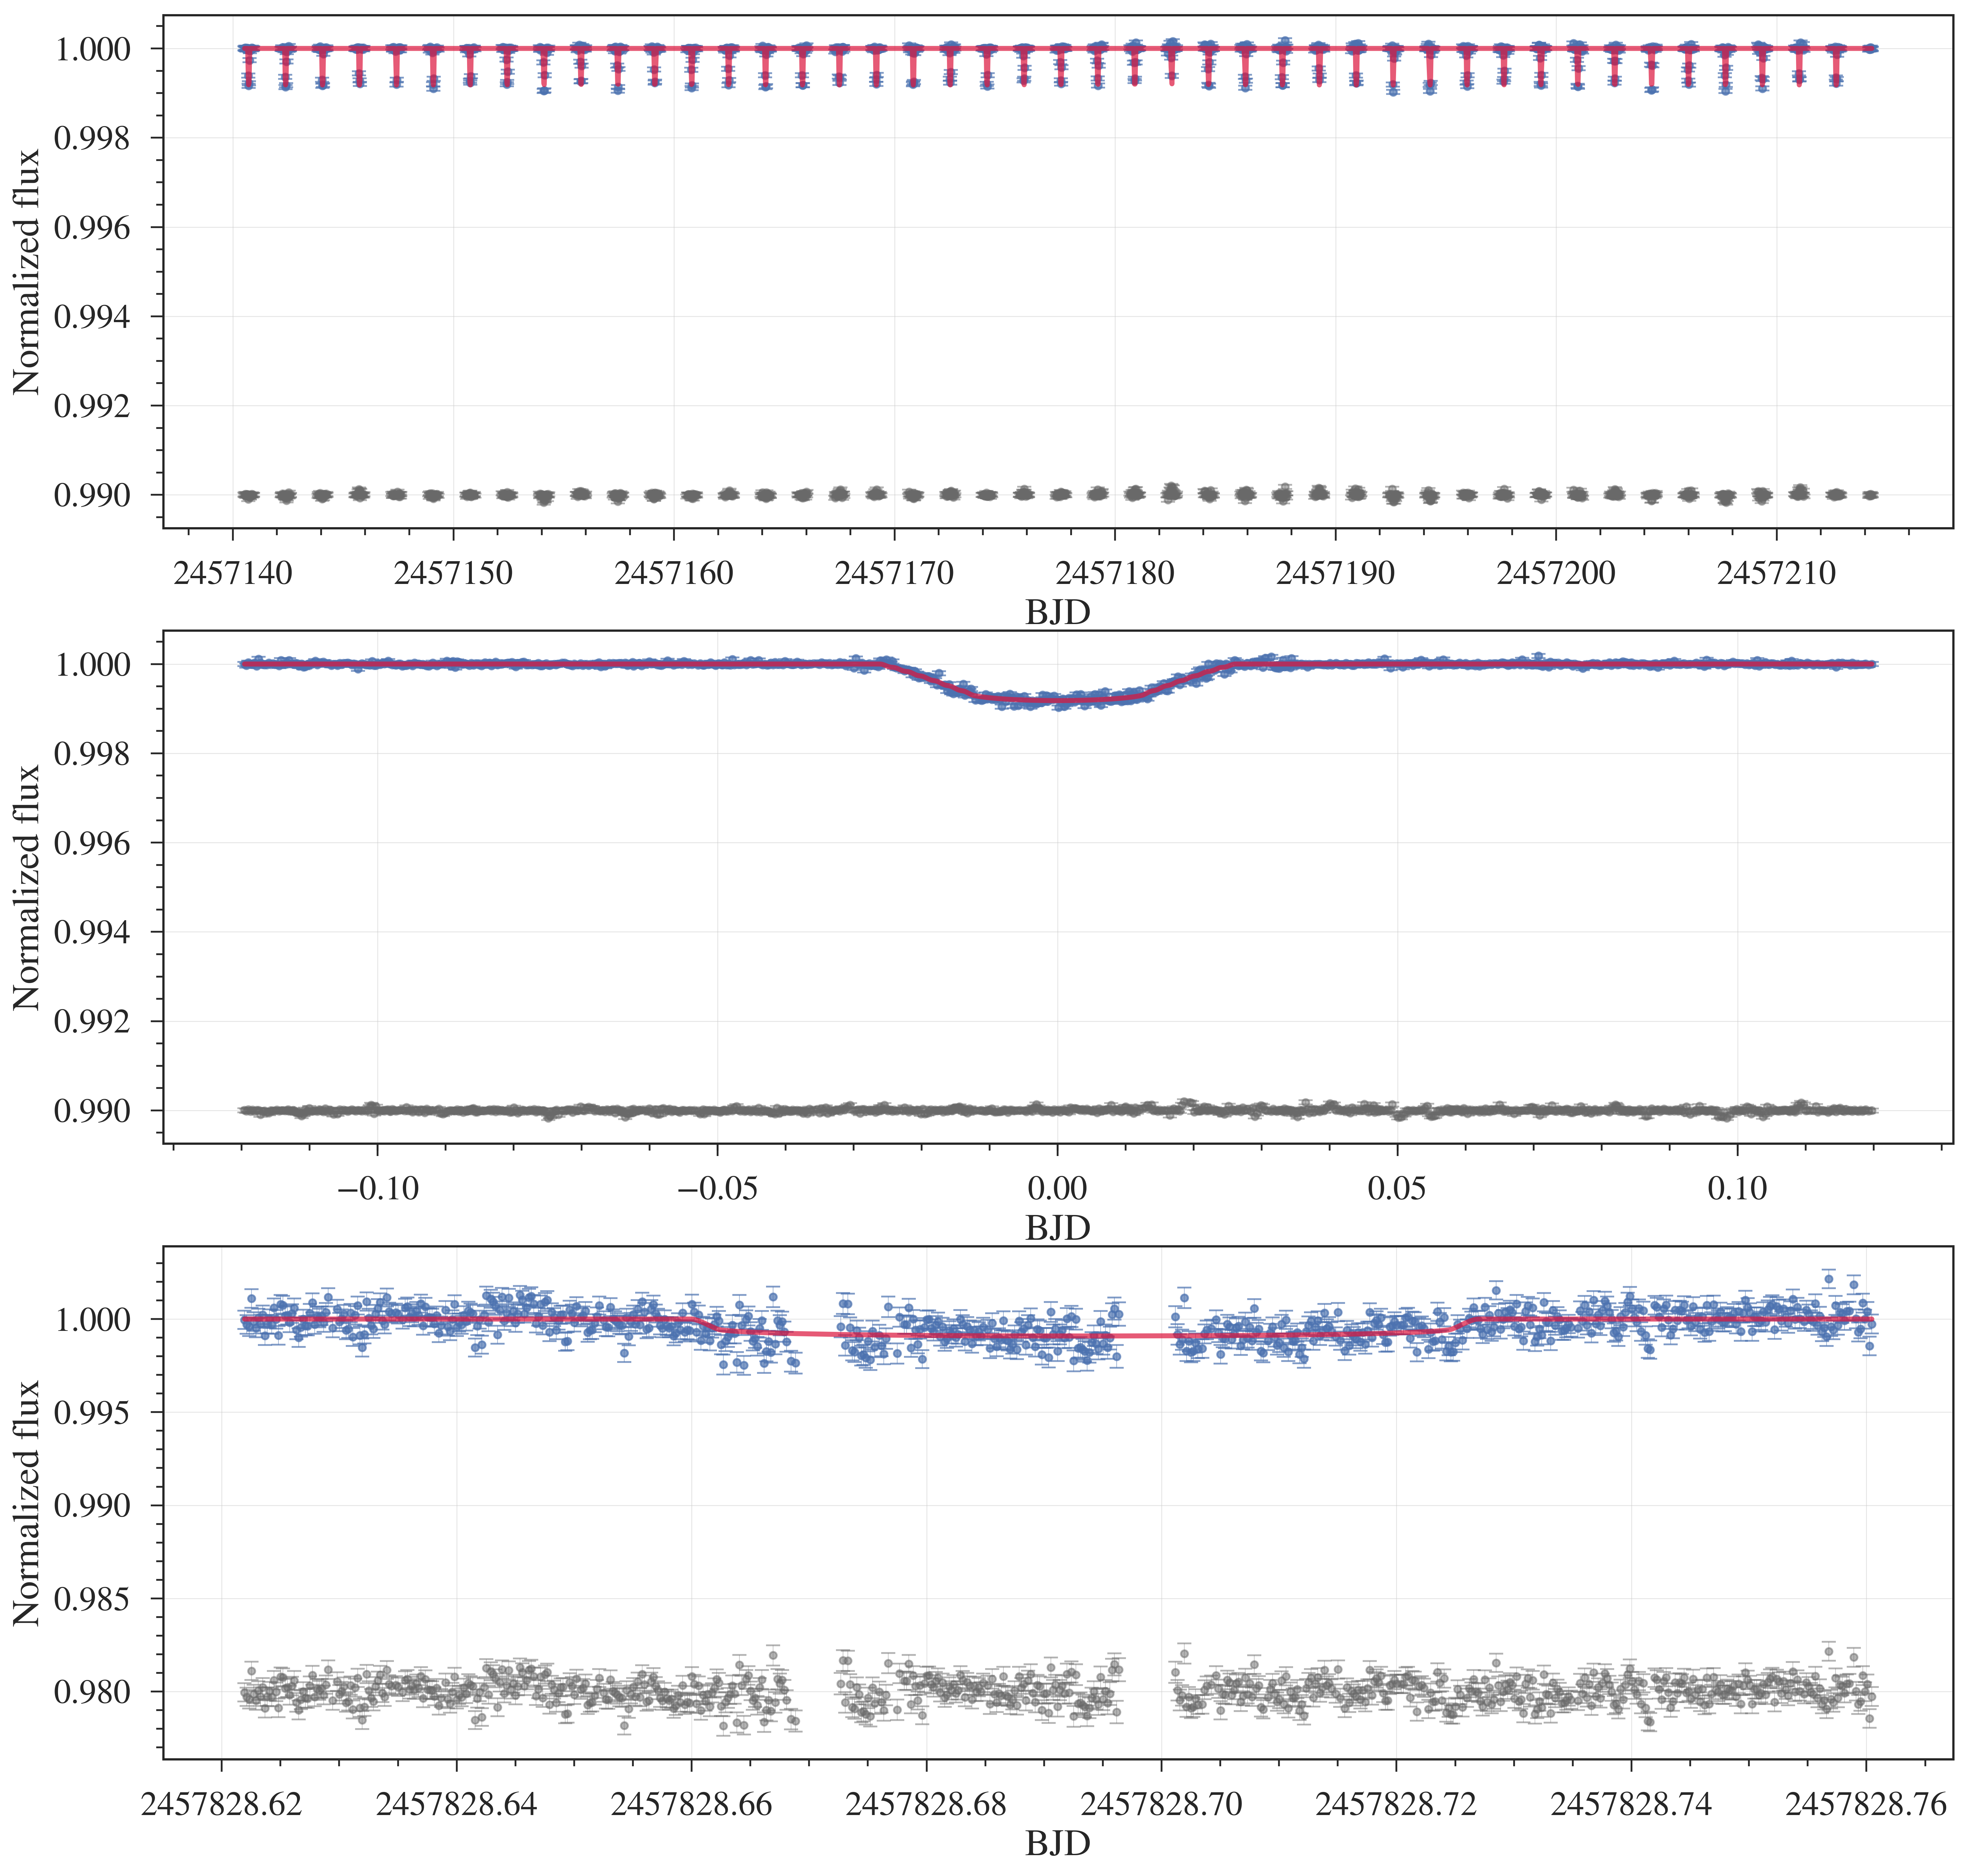

In [27]:
#df_fold_ground = pd.DataFrame(zip(phases_fit,model_trend2_no_trend,scaled_flux2),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,18))
ax,bx,cx = axx
p1=plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2_no_trend,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2_no_trend,
                        offset=0.98,ax=cx)

In [28]:
d = {'phase_fold_time_k2': df_fold.phase, 'phase_fold_scaled_flux_k2': df_fold.scaled_flux, 'scaled_error_k2':scaled_error1,
    'yresidual_k2': residual1, 'xmodel_k2':df_fold.phase, 'ymodel_k2':df_fold.model }
k2_data_for_plotting=pd.DataFrame(data=d)
k2_data_for_plotting.to_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_k2.csv")

In [29]:
d = {'time_ground': TF.lpf.data2["time"], 'scaled_flux_ground': scaled_flux2_no_trend, 'scaled_error_ground':scaled_error2,
    'yresidual_ground': residual2, 'xmodel_ground': TF.lpf.data2["time"], 'ymodel_ground':model_trend2_no_trend}
ground_data_for_plotting=pd.DataFrame(data=d)
ground_data_for_plotting.to_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_ground.csv")